In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
# from matplotlib.mlab import rec2csv

import emcee
import corner

import _pickle as cPickle
import matplotlib as mpl

In [2]:
def median_interval(data, alpha=0.32):
    """
    Median including Bayesian credible interval.

    Parameters
    ----------
    data  : posterior samples
    alpha : 1 - confidence interval

    Returns
    -------
    [med,[lo, hi]] : median, lower, and upper percentiles
    
    """
    q = [100*alpha/2., 50, 100*(1-alpha/2.)]
    lo,med,hi = np.percentile(data,q)
    return [med,[lo,hi]]

In [3]:
cat = np.genfromtxt('../forElena16Nov/SAGITTARIUS-II_cat16Nov.dat',names=True)

In [4]:
x = cat['x_f606w']
y = cat['y_f606w']
m606 = cat['magr_f606w']
dm606 = cat['err_f606w']
m814 = cat['magr_f814w']
dm814 = cat['err_f814w']

In [5]:
xgood = x
ygood = y

In [6]:
# x0 = 2386.25
# y0 = 2224.53

In [7]:
# richness = 6071
# x0 = 2527
# y0 = 2235
# gal_ext_pix = 2677

# gal_ell = 0.3
# gal_pa = -8

In [8]:
# sag_x0 = x0
# sag_y0 = y0

# sag_nstar = 4000
# sag_ext = 1.6/60 # degrees
# sag_ext_pix = 3000
# sag_ell = 0.3
# sag_pa = 70

# r_h = gal_ext_pix

In [9]:
samples_h = cPickle.load( open( "sag2mcmcPL1902-2.p", "rb" ) )
#MEDIAN VALUES AND +/-1 SIGMA FOR EACH FIT PARAMETER
rich_h,[rich_min,rich_max] = median_interval(samples_h[:,0])
x_h,[xmin,xmax] = median_interval(samples_h[:,1])
y_h,[ymin,ymax] = median_interval(samples_h[:,2])
sag2_ext_fit_h,[sag2_ext_min,sag2_ext_max] = median_interval(samples_h[:,3])
sag2_ell_fit_h,[sag2_ell_min,sag2_ell_max] = median_interval(samples_h[:,4])
sag2_pa_fit_h,[sag2_pa_min,sag2_pa_max] = median_interval(samples_h[:,5])

res = [rich_h,rich_max-rich_h,rich_h-rich_min,x_h,xmax-x_h,x_h-xmin,y_h,ymax-y_h,y_h-ymin,
           sag2_ext_fit_h,sag2_ext_max-sag2_ext_fit_h,sag2_ext_fit_h-sag2_ext_min,
           sag2_ell_fit_h,sag2_ell_max-sag2_ell_fit_h,sag2_ell_fit_h-sag2_ell_min,
           sag2_pa_fit_h,sag2_pa_max-sag2_pa_fit_h,sag2_pa_fit_h-sag2_pa_min]

print(res)

[7797.203862521483, 175.1170013876881, 169.9691550171883, 2329.9465406833224, 23.077491706560068, 23.190543779932796, 2181.2670905972664, 27.52270906633248, 27.484441464997417, 2216.950480728354, 62.63551251306626, 60.09283508331464, 0.14159011019323087, 0.02659166698660012, 0.027261593328883893, -16.455886266280395, 5.2845732523603814, 5.6478025933461815]


In [22]:
sag_x0 = x_h
sag_y0 = y_h

x0 = x_h
y0 = y_h

richness = rich_h
# sag_ext = 1.6/60 # degrees
sag_ext_pix = sag2_ext_fit_h
sag_ell = sag2_ell_fit_h
sag_pa = sag2_pa_fit_h

r_h = sag_ext_pix
gal_ext_pix = sag_ext_pix

gal_ell = sag2_ell_fit_h
gal_pa = -8

In [23]:
def new_kernel_plummer(x,y,lon=sag_x0,lat=sag_y0,ext=sag_ext_pix,ell=sag_ell,pa=sag_pa):
    """ Evaluate the elliptical Plummer kernel at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    #PLUMMER SCALE RADIUS = HALF-LIGHT RADIUS 
    r_e = ext
    #Normalization (integrates to unity over all space?) [stars/pix^2)
    norm = r_e**2/(np.pi*(1-ell))

    # Plummer PDF
    pdf = norm / ((radius**2 + r_e**2)**2)

    return pdf

In [24]:
def model(theta_sag):
    """ Calculate the binned model counts. This extends over the
    entire pixel range, but we will apply the mask later.

    Parameters
    ----------
    theta : the model parameters
    
    Returns
    -------
    model_counts : the model counts in each bin
    """
    #FIT ALL MODEL PARAMETERS
    richness = theta_sag[0]
    kwargs = dict(lon=theta_sag[1],lat=theta_sag[2],ext=theta_sag[3],ell=theta_sag[4],pa=theta_sag[5])
    #THIS CAN BE USED TO HOLD SOME OF THE PARAMETERS FIXED
    # Default values for the other parameters
    #kwargs.update(ext=ERI_EXT_PIX,ell=ERI_ELL)

    #CHANGE KERNEL CALLED HERE TO USE A DIFFERENT FUNCTIONAL FORM FOR THE SURFACE DENSITY OF THE GALAXY
    # The new kernel in pixel coordinates
    pdf = new_kernel_plummer(xx,yy,**kwargs)
#     pdf = new_kernel(xx,yy,**kwargs)

    # Calculate the model predicted counts in each pixel
    pixarea = xdel*ydel
    model_counts = richness * pdf * pixarea
    return model_counts

In [25]:
xbin0 = np.ones((179,1))  # (fltarr(267)+1)
xbin1 = np.ones((1,179))  
xbin1[0] = np.arange(0,179,1)
xbin2 = xbin1 * 30 + 15  # (findgen(267)*30. + 15)
xbin = np.matmul(xbin0,xbin2)
ybin = xbin.T

# creating x and y arrays to represent the bins across the image

In [26]:
def returnPDF(gal_pa_):
    costh = np.cos(-1 * np.deg2rad(gal_pa_))
    sinth = np.sin(-1 * np.deg2rad(gal_pa_))

    dx = xbin - x0
    dy = ybin - y0

    r1 = (dx * costh - dy * sinth) / (1 - gal_ell)
    r2 = (dx * sinth + dy * costh)

    radius = np.sqrt(r1**2 + r2**2)
    
    r_h = gal_ext_pix
    norm = r_h**2 / (np.pi * (1-gal_ell))
    # half light radius squared / (pi * 1-ell)
    pdf = norm/((radius**2 + r_h**2)**2)

    return pdf, radius

In [27]:
pdfm8, radiusm8 = returnPDF(-8)
pdfm48, radiusm48 = returnPDF(-48)
pdf32, radius32 = returnPDF(32)
pdf82, radius82 = returnPDF(82)

In [28]:
xdel = 30.
ydel = 30.
pixarea = xdel*ydel  # pixel area in each bin

In [29]:
model_counts_galm8 = richness*pdfm8*pixarea  # a 179x179 array
model_counts_galm48 = richness*pdfm48*pixarea  # a 179x179 array
model_counts_gal32 = richness*pdf32*pixarea  # a 179x179 array
model_counts_gal82 = richness*pdf82*pixarea  # a 179x179 array

In [30]:
# Observed surface density map
binned_surface_density_30 = np.zeros((179,179))
for ii in range(179):
    for jj in range(179):
        idxgood = np.logical_and(np.logical_and(xgood >= (30 * ii),xgood <= (30 * (ii + 1))),
                     np.logical_and(ygood >= (30 * jj),ygood <= (30 * (jj + 1))))

        tmp = np.where(idxgood)[0]
#         # flipping ii and jj because in IDL, it's col, row.
        binned_surface_density_30[jj,ii] = len(tmp)

In [31]:
# Define annuli
radius1_m8=radiusm8.flatten()
r1_m8 = np.where(radius1_m8 < (0.1 * r_h))[0]
r2_m8 = np.where((radius1_m8 < (0.2 * r_h)) & (radius1_m8 >= (0.1 * r_h)))[0]
r3_m8 = np.where((radius1_m8 < (0.3 * r_h)) & (radius1_m8 >= (0.2 * r_h)))[0]
r4_m8 = np.where((radius1_m8 < (0.4 * r_h)) & (radius1_m8 >= (0.3 * r_h)))[0]
r5_m8 = np.where((radius1_m8 < (0.5 * r_h)) & (radius1_m8 >= (0.4 * r_h)))[0]
r6_m8 = np.where((radius1_m8 < (0.6 * r_h)) & (radius1_m8 >= (0.5 * r_h)))[0]
r7_m8 = np.where((radius1_m8 < (0.7 * r_h)) & (radius1_m8 >= (0.6 * r_h)))[0]
r8_m8 = np.where((radius1_m8 < (0.8 * r_h)) & (radius1_m8 >= (0.7 * r_h)))[0]
r9_m8 = np.where((radius1_m8 < (0.9 * r_h)) & (radius1_m8 >= (0.8 * r_h)))[0]
r10_m8 = np.where((radius1_m8 < r_h) & (radius1_m8 >= (0.9 * r_h)))[0]

In [32]:
# Define annuli
radius1_m48=radiusm48.flatten()
r1_m48 = np.where(radius1_m48 < (0.1 * r_h))[0]
r2_m48 = np.where((radius1_m48 < (0.2 * r_h)) & (radius1_m48 >= (0.1 * r_h)))[0]
r3_m48 = np.where((radius1_m48 < (0.3 * r_h)) & (radius1_m48 >= (0.2 * r_h)))[0]
r4_m48 = np.where((radius1_m48 < (0.4 * r_h)) & (radius1_m48 >= (0.3 * r_h)))[0]
r5_m48 = np.where((radius1_m48 < (0.5 * r_h)) & (radius1_m48 >= (0.4 * r_h)))[0]
r6_m48 = np.where((radius1_m48 < (0.6 * r_h)) & (radius1_m48 >= (0.5 * r_h)))[0]
r7_m48 = np.where((radius1_m48 < (0.7 * r_h)) & (radius1_m48 >= (0.6 * r_h)))[0]
r8_m48 = np.where((radius1_m48 < (0.8 * r_h)) & (radius1_m48 >= (0.7 * r_h)))[0]
r9_m48 = np.where((radius1_m48 < (0.9 * r_h)) & (radius1_m48 >= (0.8 * r_h)))[0]
r10_m48 = np.where((radius1_m48 < r_h) & (radius1_m48 >= (0.9 * r_h)))[0]

In [33]:
# Define annuli
radius1_32=radius32.flatten()
r1_32 = np.where(radius1_32 < (0.1 * r_h))[0]
r2_32 = np.where((radius1_32 < (0.2 * r_h)) & (radius1_32 >= (0.1 * r_h)))[0]
r3_32 = np.where((radius1_32 < (0.3 * r_h)) & (radius1_32 >= (0.2 * r_h)))[0]
r4_32 = np.where((radius1_32 < (0.4 * r_h)) & (radius1_32 >= (0.3 * r_h)))[0]
r5_32 = np.where((radius1_32 < (0.5 * r_h)) & (radius1_32 >= (0.4 * r_h)))[0]
r6_32 = np.where((radius1_32 < (0.6 * r_h)) & (radius1_32 >= (0.5 * r_h)))[0]
r7_32 = np.where((radius1_32 < (0.7 * r_h)) & (radius1_32 >= (0.6 * r_h)))[0]
r8_32 = np.where((radius1_32 < (0.8 * r_h)) & (radius1_32 >= (0.7 * r_h)))[0]
r9_32 = np.where((radius1_32 < (0.9 * r_h)) & (radius1_32 >= (0.8 * r_h)))[0]
r10_32 = np.where((radius1_32 < r_h) & (radius1_32 >= (0.9 * r_h)))[0]

In [34]:
# Define annuli
radius1_82=radius82.flatten()
r1_82 = np.where(radius1_82 < (0.1 * r_h))[0]
r2_82 = np.where((radius1_82 < (0.2 * r_h)) & (radius1_82 >= (0.1 * r_h)))[0]
r3_82 = np.where((radius1_82 < (0.3 * r_h)) & (radius1_82 >= (0.2 * r_h)))[0]
r4_82 = np.where((radius1_82 < (0.4 * r_h)) & (radius1_82 >= (0.3 * r_h)))[0]
r5_82 = np.where((radius1_82 < (0.5 * r_h)) & (radius1_82 >= (0.4 * r_h)))[0]
r6_82 = np.where((radius1_82 < (0.6 * r_h)) & (radius1_82 >= (0.5 * r_h)))[0]
r7_82 = np.where((radius1_82 < (0.7 * r_h)) & (radius1_82 >= (0.6 * r_h)))[0]
r8_82 = np.where((radius1_82 < (0.8 * r_h)) & (radius1_82 >= (0.7 * r_h)))[0]
r9_82 = np.where((radius1_82 < (0.9 * r_h)) & (radius1_82 >= (0.8 * r_h)))[0]
r10_82 = np.where((radius1_82 < r_h) & (radius1_82 >= (0.9 * r_h)))[0]

In [35]:
arr = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
r_annuli = (arr + 0.05) * r_h

# .05r_h, .15r_h
area_annuli = np.pi * ( (r_annuli + (0.05*r_h))**2 - (r_annuli - (0.05*r_h))**2) * (1-gal_ell)

In [36]:
pix_per_arcsec=20
area_arcmin = area_annuli/(pix_per_arcsec*60)**2

In [37]:
aa = area_arcmin
dist_x = np.array([r_h*0.1,r_h*0.2,r_h*0.3,r_h*0.4,r_h*0.5,r_h*0.6,r_h*0.7,r_h*0.8,r_h*0.9,r_h])/1200

In [38]:
binned_surface_density_30f = binned_surface_density_30.flatten()
model_counts_galfm8 = model_counts_galm8.flatten()
model_counts_galfm48 = model_counts_galm48.flatten()
model_counts_galf32 = model_counts_gal32.flatten()
model_counts_galf82 = model_counts_gal82.flatten()
# model_counts_expf = model_counts_exp.flatten()
data_1dm8 = [binned_surface_density_30f[r1_m8].sum()/aa[0],
           binned_surface_density_30f[r2_m8].sum()/aa[1],
           binned_surface_density_30f[r3_m8].sum()/aa[2],
           binned_surface_density_30f[r4_m8].sum()/aa[3],
           binned_surface_density_30f[r5_m8].sum()/aa[4],
           binned_surface_density_30f[r6_m8].sum()/aa[5],
           binned_surface_density_30f[r7_m8].sum()/aa[6],
           binned_surface_density_30f[r8_m8].sum()/aa[7],
           binned_surface_density_30f[r9_m8].sum()/aa[8],
           binned_surface_density_30f[r10_m8].sum()/aa[9]]

data_1dm48 = [binned_surface_density_30f[r1_m48].sum()/aa[0],
           binned_surface_density_30f[r2_m48].sum()/aa[1],
           binned_surface_density_30f[r3_m48].sum()/aa[2],
           binned_surface_density_30f[r4_m48].sum()/aa[3],
           binned_surface_density_30f[r5_m48].sum()/aa[4],
           binned_surface_density_30f[r6_m48].sum()/aa[5],
           binned_surface_density_30f[r7_m48].sum()/aa[6],
           binned_surface_density_30f[r8_m48].sum()/aa[7],
           binned_surface_density_30f[r9_m48].sum()/aa[8],
           binned_surface_density_30f[r10_m48].sum()/aa[9]]

data_1d32 = [binned_surface_density_30f[r1_32].sum()/aa[0],
           binned_surface_density_30f[r2_32].sum()/aa[1],
           binned_surface_density_30f[r3_32].sum()/aa[2],
           binned_surface_density_30f[r4_32].sum()/aa[3],
           binned_surface_density_30f[r5_32].sum()/aa[4],
           binned_surface_density_30f[r6_32].sum()/aa[5],
           binned_surface_density_30f[r7_32].sum()/aa[6],
           binned_surface_density_30f[r8_32].sum()/aa[7],
           binned_surface_density_30f[r9_32].sum()/aa[8],
           binned_surface_density_30f[r10_32].sum()/aa[9]]

data_1d82 = [binned_surface_density_30f[r1_82].sum()/aa[0],
           binned_surface_density_30f[r2_82].sum()/aa[1],
           binned_surface_density_30f[r3_82].sum()/aa[2],
           binned_surface_density_30f[r4_82].sum()/aa[3],
           binned_surface_density_30f[r5_82].sum()/aa[4],
           binned_surface_density_30f[r6_82].sum()/aa[5],
           binned_surface_density_30f[r7_82].sum()/aa[6],
           binned_surface_density_30f[r8_82].sum()/aa[7],
           binned_surface_density_30f[r9_82].sum()/aa[8],
           binned_surface_density_30f[r10_82].sum()/aa[9]]

model_1dm8 = [model_counts_galfm8[r1_m8].sum()/aa[0],
            model_counts_galfm8[r2_m8].sum()/aa[1],
            model_counts_galfm8[r3_m8].sum()/aa[2],
            model_counts_galfm8[r4_m8].sum()/aa[3],
            model_counts_galfm8[r5_m8].sum()/aa[4],
            model_counts_galfm8[r6_m8].sum()/aa[5],
            model_counts_galfm8[r7_m8].sum()/aa[6],
            model_counts_galfm8[r8_m8].sum()/aa[7],
            model_counts_galfm8[r9_m8].sum()/aa[8],
            model_counts_galfm8[r10_m8].sum()/aa[9]]

In [39]:
model_1dm48 = [model_counts_galfm48[r1_m48].sum()/aa[0],
            model_counts_galfm48[r2_m48].sum()/aa[1],
            model_counts_galfm48[r3_m48].sum()/aa[2],
            model_counts_galfm48[r4_m48].sum()/aa[3],
            model_counts_galfm48[r5_m48].sum()/aa[4],
            model_counts_galfm48[r6_m48].sum()/aa[5],
            model_counts_galfm48[r7_m48].sum()/aa[6],
            model_counts_galfm48[r8_m48].sum()/aa[7],
            model_counts_galfm48[r9_m48].sum()/aa[8],
            model_counts_galfm48[r10_m48].sum()/aa[9]]

model_1d32 = [model_counts_galf32[r1_32].sum()/aa[0],
            model_counts_galf32[r2_32].sum()/aa[1],
            model_counts_galf32[r3_32].sum()/aa[2],
            model_counts_galf32[r4_32].sum()/aa[3],
            model_counts_galf32[r5_32].sum()/aa[4],
            model_counts_galf32[r6_32].sum()/aa[5],
            model_counts_galf32[r7_32].sum()/aa[6],
            model_counts_galf32[r8_32].sum()/aa[7],
            model_counts_galf32[r9_32].sum()/aa[8],
            model_counts_galf32[r10_32].sum()/aa[9]]

model_1d82 = [model_counts_galf82[r1_82].sum()/aa[0],
            model_counts_galf82[r2_82].sum()/aa[1],
            model_counts_galf82[r3_82].sum()/aa[2],
            model_counts_galf82[r4_82].sum()/aa[3],
            model_counts_galf82[r5_82].sum()/aa[4],
            model_counts_galf82[r6_82].sum()/aa[5],
            model_counts_galf82[r7_82].sum()/aa[6],
            model_counts_galf82[r8_82].sum()/aa[7],
            model_counts_galf82[r9_82].sum()/aa[8],
            model_counts_galf82[r10_82].sum()/aa[9]]

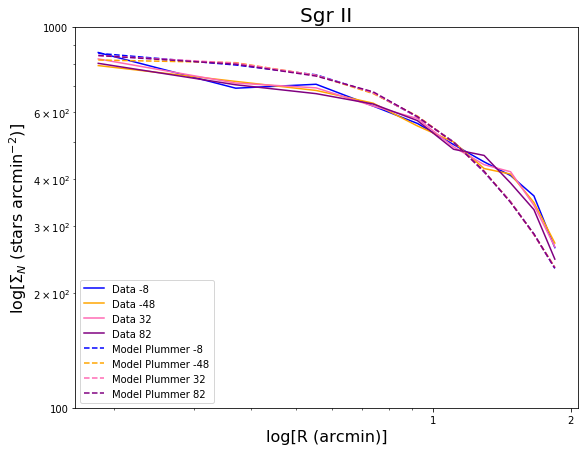

In [41]:
fig, ax = plt.subplots(figsize=(9,7))

ax.plot(dist_x,data_1dm8,label='Data -8',color='blue')
ax.plot(dist_x,data_1dm48,label='Data -48',color='orange')
ax.plot(dist_x,data_1d32,label='Data 32',color='hotpink')
ax.plot(dist_x,data_1d82,label='Data 82',color='purple')
ax.plot(dist_x,model_1dm8,label='Model Plummer -8',color='blue',linestyle='--')
ax.plot(dist_x,model_1dm48,label='Model Plummer -48',color='orange',linestyle='--')
ax.plot(dist_x,model_1d32,label='Model Plummer 32',color='hotpink',linestyle='--')
ax.plot(dist_x,model_1d82,label='Model Plummer 82',color='purple',linestyle='--')

# ax.plot(dist_x,model_1de,label='Model Exp')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'log[$\Sigma_N$ (stars arcmin$^{-2}$)]',fontsize=16)
ax.set_xlabel(r'log[R (arcmin)]',fontsize=16)
ax.set_title('Sgr II',fontsize=20)

ax.set_xticks([1, 2])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_yticks([1e+2, 1e+3])
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.legend()
plt.savefig('figures/sgr2_2202pa.png')
plt.show()